# Semantic Segmentation


1.Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>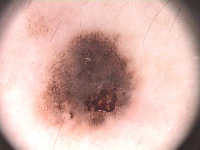</td><td>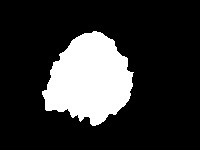</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем сегментировать их.

In [0]:
! wget https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar

--2020-06-01 11:17:59--  https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.1, 2620:100:6018:1::a27d:301
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/k88qukc20ljnbuo/PH2Dataset.rar [following]
--2020-06-01 11:17:59--  https://www.dropbox.com/s/raw/k88qukc20ljnbuo/PH2Dataset.rar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc0feac94d58fc6afd3c8b6e8cea.dl.dropboxusercontent.com/cd/0/inline/A418hTL4UBP3klxB8NFVfEJmEWrFrNR0Nd8elqxebp4pMuT1DUGbAxvZNkRbBpaqxiJwVQvZJE1JPtSV_0_CUArDgIv3Ni5yt4KF8mfM_-U9Hw/file# [following]
--2020-06-01 11:18:00--  https://uc0feac94d58fc6afd3c8b6e8cea.dl.dropboxusercontent.com/cd/0/inline/A418hTL4UBP3klxB8NFVfEJmEWrFrNR0Nd8elqxebp4pMuT1DUGbAxvZNkRbBpaqxiJwVQvZJE1JPtSV_0_CUArDgIv3Ni5yt4KF8mfM_-U9Hw/file
Resolving uc0

In [0]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

Для загрузки датасета я предлагаю использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [0]:
!ls PH2Dataset/'PH2 Dataset images'/IMD002

IMD002_Dermoscopic_Image  IMD002_lesion  IMD002_roi


In [0]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize) можно использовать для изменения размера изображений. 
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [0]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [0]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [0]:
len(lesions)

200

In [0]:
print(X.shape)
print(Y.shape)

(200, 256, 256, 3)
(200, 256, 256)


Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

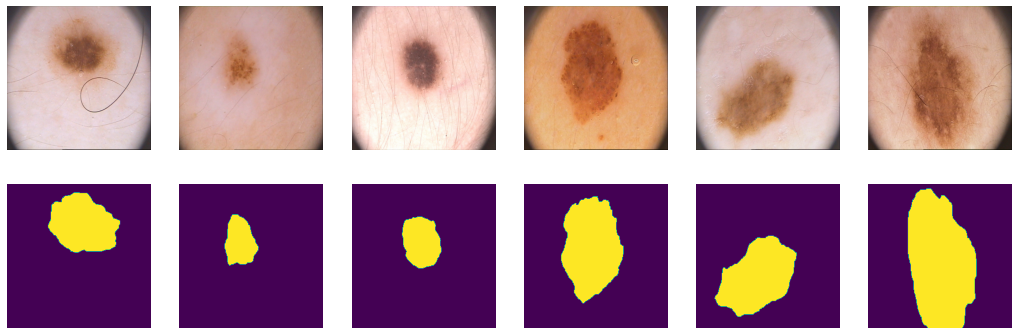

In [0]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для валидации и теста

In [0]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [0]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [0]:
# adds one canal to Y array and moves canal axis (there's 3 canals in 
# X array) to the first position 

from torch.utils.data import DataLoader
batch_size = 10#25
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [0]:
print(X[ts].shape)
print(np.rollaxis(X[ts], 3, 1).shape)
print(Y[ts].shape)
print(Y[ts, np.newaxis].shape)

(50, 256, 256, 3)
(50, 3, 256, 256)
(50, 256, 256)
(50, 1, 256, 256)


In [0]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

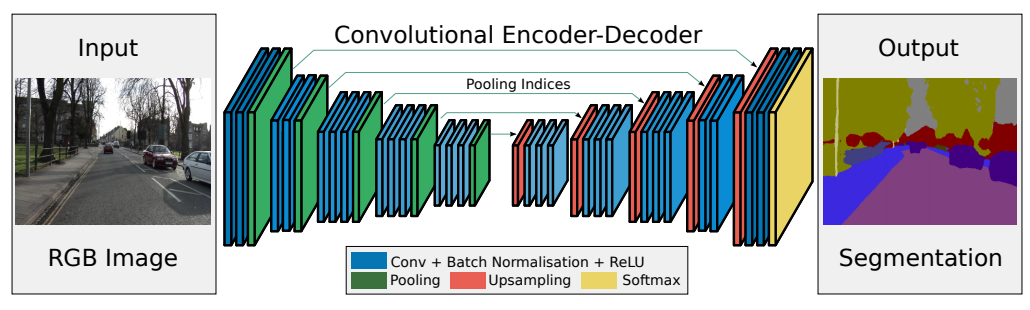

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim #as optim
from time import time

torch.manual_seed(42)
np.random.seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [0]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(32)
        )
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, return_indices=True)# 256 -> 128
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(64)
        )
        self.pool1 =  nn.MaxPool2d(kernel_size=2, stride=2, padding=0, return_indices=True)# 128 -> 64
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), 
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), 
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), 
            nn.BatchNorm2d(128)
        )
        self.pool2 =  nn.MaxPool2d(kernel_size=2, stride=2, padding=0, return_indices=True)# 64 -> 32
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512)
        )
        self.pool3 =  nn.MaxPool2d(kernel_size=2, stride=2, padding=0, return_indices=True)# 32 -> 16
        
        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(2, stride=2) # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128)
        )
        self.upsample1 = nn.MaxUnpool2d(2, stride=2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(64)
        )
        self.upsample2 = nn.MaxUnpool2d(2, stride=2) # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(32)
        )
        self.upsample3 = nn.MaxUnpool2d(2, stride=2) # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )

    def forward(self, x):
        # encoder
        e0, e0_maxpool_indices = self.pool0(F.relu(self.enc_conv0(x)))
        e1, e1_maxpool_indices  = self.pool1(F.relu(self.enc_conv1(e0)))
        e2, e2_maxpool_indices  = self.pool2(F.relu(self.enc_conv2(e1)))
        e3, e3_maxpool_indices  = self.pool3(F.relu(self.enc_conv3(e2)))

        # decoder
        d0 = F.relu(self.dec_conv0(self.upsample0(e3, e3_maxpool_indices)))
        d1 = F.relu(self.dec_conv1(self.upsample1(d0, e2_maxpool_indices)))
        d2 = F.relu(self.dec_conv2(self.upsample2(d1, e1_maxpool_indices)))
        d3 = self.dec_conv3(self.upsample3(d2, e0_maxpool_indices)) # no activation
        return d3

In [0]:
def visualize(train_loss, val_loss, train_score, val_score):
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label = 'train_loss')
    plt.plot(val_loss, label = 'val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(train_score, label = 'train_score')
    plt.plot(val_score, label = 'val_score')
    plt.title('Score')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.legend()
    plt.show()

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


To clarify this we can see on the segmentation:
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


And the intersection will be the following:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [0]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W 
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    # sum((1, 2)) -> BATCH x H x W = (0, 1, 2) -> sum((H, W)) -> returns for each picture in batch -> returns size BATCH x 1
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded  # 























































































## функция лосса [1 балл]

Теперь не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации. 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits) в Тарая функция эквивалентна и не так подвержена численной неустойчивости.

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [0]:
def bce_loss(y_real, y_pred):
    return (y_pred - y_real * y_pred + torch.log(1 + torch.exp(-y_pred))).mean()

## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [0]:
def train(model, opt, loss_fn, epochs, data_tr, data_val, scheduler, path):
    X_val, Y_val = next(iter(data_val))
    X_val = X_val.to(device)
    Y_val = Y_val.to(device)

    train_loss = []
    val_loss = []
    train_score = []
    val_score = []
    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        avg_train_score = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            # set parameter gradients to zero
            opt.zero_grad()
            # forward
            with torch.set_grad_enabled(True):
                Y_pred = model(X_batch)
                
                avg_train_score += iou_pytorch(Y_pred>0, Y_batch).mean().item()

                loss =  loss_fn(Y_batch, Y_pred)# forward-pass
                loss.backward()  # backward-pass
                opt.step()  # update weights

                scheduler.step()
        # calculate loss to show the user
            avg_loss += loss / len(data_tr)

        avg_train_score = avg_train_score / len(data_tr)
          
        train_score.append(avg_train_score)
        train_loss.append(avg_loss)

        toc = time()
        print('loss: %f' % avg_loss)
        
        avg_val_loss = 0
        avg_val_score = 0
        # show intermediate results
        model.eval()  # testing mode

        for X_val_batch, Y_val_batch in data_val:
            # data to device
            X_val_batch = X_val_batch.to(device)
            Y_val_batch = Y_val_batch.to(device)
            # set parameter gradients to zero
            # forward
            with torch.set_grad_enabled(False):
                Y_val_pred = model(X_val_batch)
                vall_loss =  loss_fn(Y_val_batch, Y_val_pred)# forward-pass
            avg_val_score += iou_pytorch(Y_val_pred >0, Y_val_batch).mean().item()
            # calculate loss to show the user
            avg_val_loss += vall_loss / len(data_val)

        val_loss.append(avg_val_loss)
        avg_val_score = avg_val_score / len(data_val)
        val_score.append(avg_val_score)

        Y_hat = model(X_val).detach().cpu()# detach and put into cpu

        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].cpu().numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0]>0, cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()

    torch.save(model, path)   
    return train_loss, val_loss, train_score, val_score

## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [0]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [model(X_batch.to(device)) for X_batch, _ in data] 
    return np.array(Y_pred)

In [0]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        Y_pred = model(X_batch.to(device))
        scores += metric(Y_pred>0, Y_label.to(device)).mean().item()

    return scores/len(data)

## Основной момент: обучение

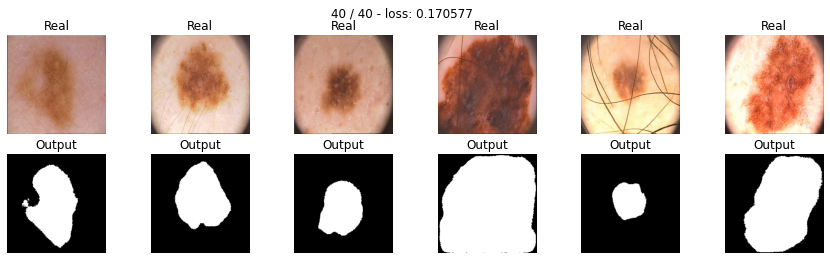

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type SegNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
model = SegNet().to(device)
path = 'segnet_bce.pt'
max_epochs = 40
optimizer = torch.optim.Adam(model.parameters())
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
train_loss_segnet_bce, val_loss_segnet_bce, train_score_segnet_bce, val_score_segnet_bce = train(model, optimizer, bce_loss, max_epochs, data_tr, data_val, scheduler, path)

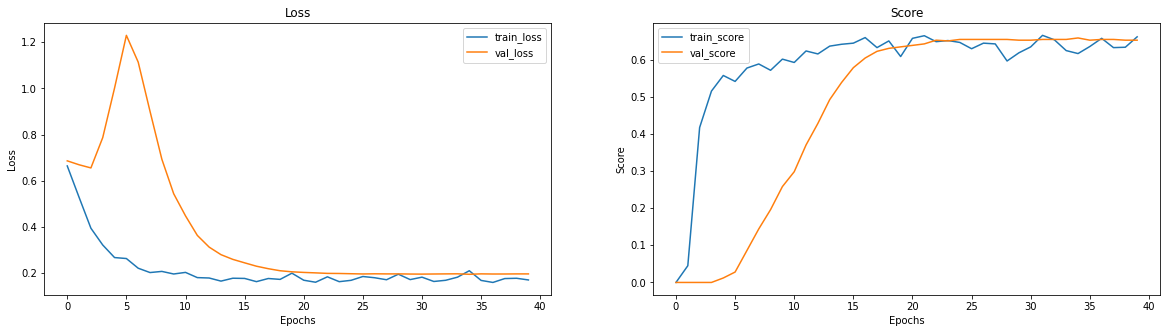

In [0]:
visualize(train_loss_segnet_bce, val_loss_segnet_bce, train_score_segnet_bce, val_score_segnet_bce)

In [0]:
path = 'segnet_bce.pt'
model = torch.load(path)
print(score_model(model, iou_pytorch, data_val))
print(score_model(model, iou_pytorch, data_ts))

0.656000018119812
0.6679999828338623


-----------------------------------------------------------------------------------------

## Дополнительные функции лосса [2 балла] 

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \sum_i\frac{2X_iY_i}{X_i+Y_i}.$$

//  Не забудьте подумать о численной нестабильности.


In [0]:
def dice_loss(y_real, y_pred):
    y_pred = torch.sigmoid(y_pred)
    epsilon = 1e-6
    axes = tuple(range(1,len(y_pred.shape)-1))
    num = torch.sum(2.*y_pred*y_real,axes)
    den =  torch.sum(y_pred+y_real,axes)
    res = torch.mean(1-(num+epsilon)/(den+epsilon)) 
    return res 

Проводим тестирование:

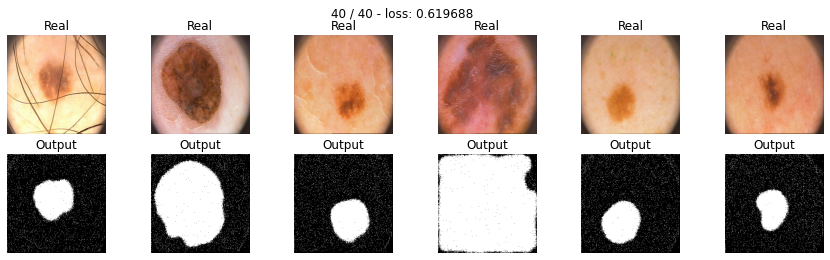

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type SegNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
model_dice = SegNet().to(device)
path = 'segnet_dice.pt'
max_epochs = 40
optimizer = torch.optim.Adam(model_dice.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
train_loss_segnet_dice, val_loss_segnet_dice, train_score_segnet_dice, val_score_segnet_dice = train(model_dice, optimizer, dice_loss, max_epochs, data_tr, data_val, scheduler, path)

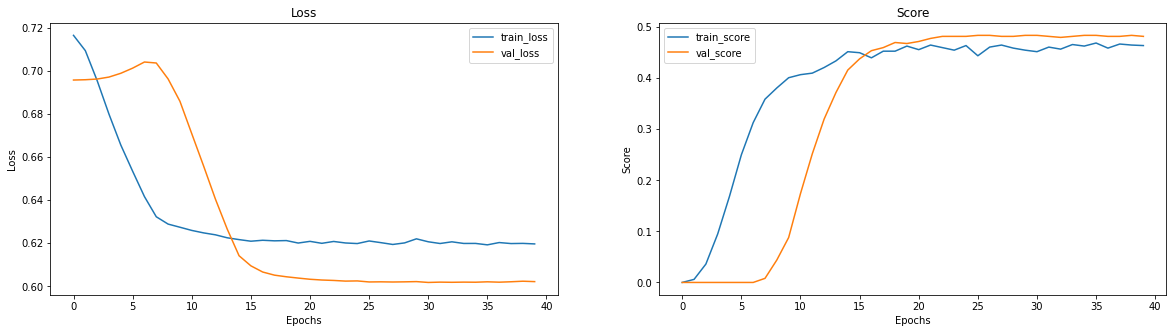

In [0]:
visualize(train_loss_segnet_dice, val_loss_segnet_dice, train_score_segnet_dice, val_score_segnet_dice)

In [0]:
path = 'segnet_dice.pt'
model = torch.load(path)
print(score_model(model, iou_pytorch, data_val))
print(score_model(model, iou_pytorch, data_ts))

0.482000008225441
0.30400000512599945


[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [0]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
    bce = torch.max(y_pred, torch.zeros_like(y_pred)) - y_real * y_pred + torch.log(1 + torch.exp(-torch.abs(y_pred)))
    your_loss = (1 - y_real*torch.sigmoid(y_pred) - (1-y_real)*(1 - torch.sigmoid(y_pred)))**gamma * bce
    return torch.clamp(your_loss.mean(), min=0)


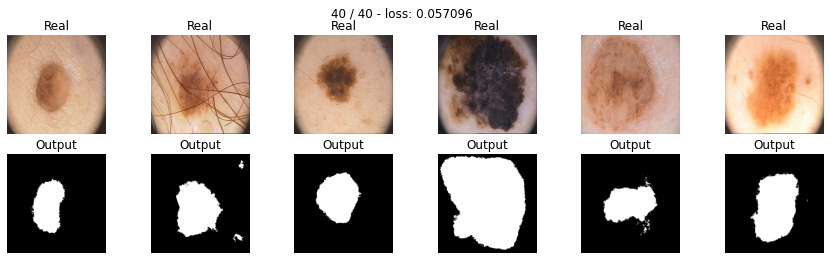

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type SegNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
model_focal = SegNet().to(device)
path = 'segnet_focal.pt'
max_epochs = 40
optimizer = torch.optim.Adam(model_focal.parameters())
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
train_loss_segnet_focal, val_loss_segnet_focal, train_score_segnet_focal, val_score_segnet_focal = train(model_focal, optimizer, focal_loss, max_epochs, data_tr, data_val, scheduler, path)

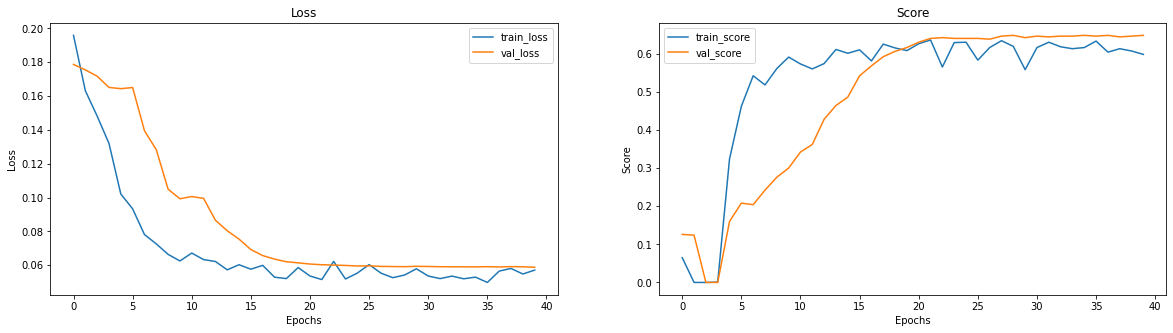

In [0]:
visualize(train_loss_segnet_focal, val_loss_segnet_focal, train_score_segnet_focal, val_score_segnet_focal)

In [0]:
path = 'segnet_focal.pt'
model = torch.load(path)
print(score_model(model, iou_pytorch, data_val))
print(score_model(model, iou_pytorch, data_ts))

0.648000031709671
0.5040000230073929


----------------------------------------------------------------------------------------------

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаю написать вам 1 функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее. Кроме тако провести численное сравнение с предыдущими функциями.
Какие варианты? 

1) Можно учесть Total Variation
2) Lova
3) BCE но с Soft Targets (что-то типа label-smoothing для многослассовой классификации)
4) Tversky loss
5) Любой другой 

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

<div style="border-left: solid 6px #d6d6d6; padding: 10px; background-color: #eaeaea">
<b><i>Exercise:</i></b> Add the total variation term to the loss.</div>

In [0]:
def tversky_loss(y_real, y_pred, beta=0.15):
  smooth = 1e-8
  y_pred = torch.sigmoid(y_pred)
  axes = tuple(range(1,len(y_pred.shape)-1))
  nom = torch.sum(y_real * y_pred, axes)
  den = torch.sum(y_real * y_pred + beta*(1 - y_real)*y_pred + (1 - beta)*y_real*(1 - y_pred), axes)
  return torch.mean(1 - (nom + smooth) / (den + smooth))  

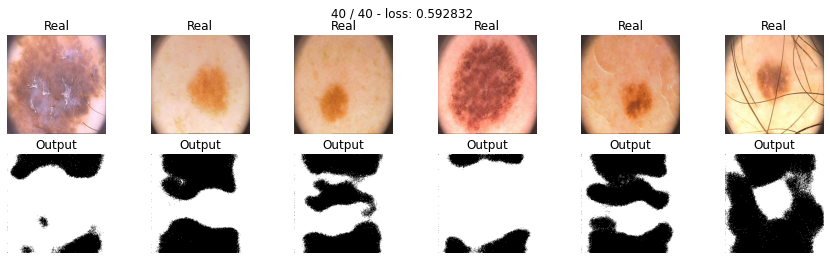

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type SegNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
# beta = 0.9
model_tversky = SegNet().to(device)
path = 'segnet_tversky.pt'
max_epochs = 40
optimizer = torch.optim.Adam(model_tversky.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
train_loss_segnet_tversky, val_loss_segnet_tversky, train_score_segnet_tversky, val_score_segnet_tversky = train(model_tversky, optimizer, tversky_loss, max_epochs, data_tr, data_val, scheduler, path)

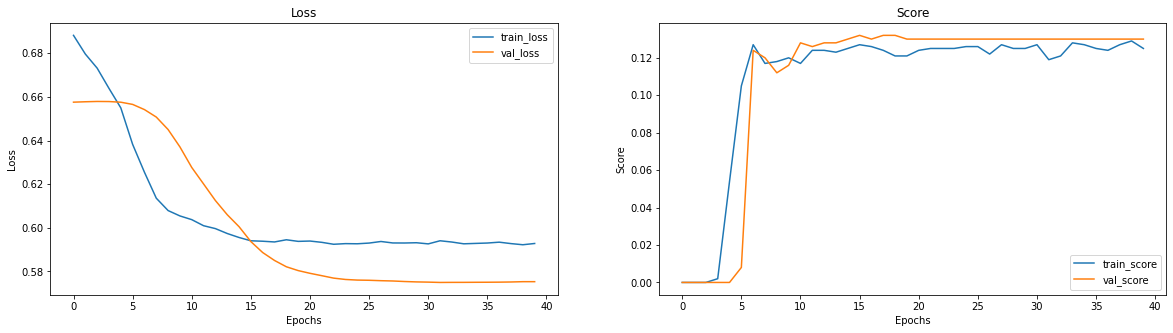

In [0]:
visualize(train_loss_segnet_tversky, val_loss_segnet_tversky, train_score_segnet_tversky, val_score_segnet_tversky)

In [0]:
path = 'segnet_tversky.pt'
model = torch.load(path)
print(score_model(model, iou_pytorch, data_val))
print(score_model(model, iou_pytorch, data_ts))

0.12999999523162842
0.06599999777972698


Изменение параметра beta повысило скор модели по сравнению с dice_loss.

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Учитывая медицинское изображение, он выводит изображение в оттенках серого, представляющее вероятность того, что каждый пиксель является интересующей областью.

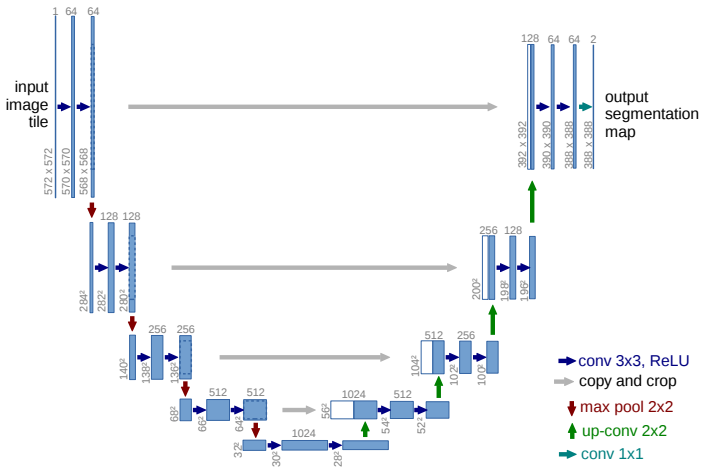

У нас в архитектуре все так же существует енкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются skip-conenctions. Элементы соединяющие части декодера и енкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [0]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(64),
            nn.ReLU()

        )
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)# 256 -> 128
        self.enc_conv1 =  nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0) # 128 -> 64
        self.enc_conv2 =  nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # 64 -> 32
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU()
        ) 

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True) # 16 -> 32
        self.dec_conv0 =  nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256),
            nn.ReLU()
        ) 
        self.upsample1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)  # 32 -> 64
        self.dec_conv1 =  nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )  
        self.upsample2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)    # 64 -> 128
        self.dec_conv2 =  nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )   
        self.upsample3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)     # 128 -> 256
        self.dec_conv3 =  nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0))
        )   

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        e1 = self.enc_conv1(self.pool0(e0))
        e2 = self.enc_conv2(self.pool1(e1))
        e3 = self.enc_conv3(self.pool2(e2))

        # bottleneck
        b = self.bottleneck_conv(self.pool3(e3))

        # decoder
        # concatenate over channels dim=1
        d0 = self.dec_conv0(torch.cat([self.upsample0(b), e3], dim=1))
        d1 = self.dec_conv1(torch.cat([self.upsample1(d0), e2], dim=1))
        d2 = self.dec_conv2(torch.cat([self.upsample2(d1), e1], dim=1))
        d3 = self.dec_conv3(torch.cat([self.upsample3(d2), e0], dim=1)) # no activation
        return d3

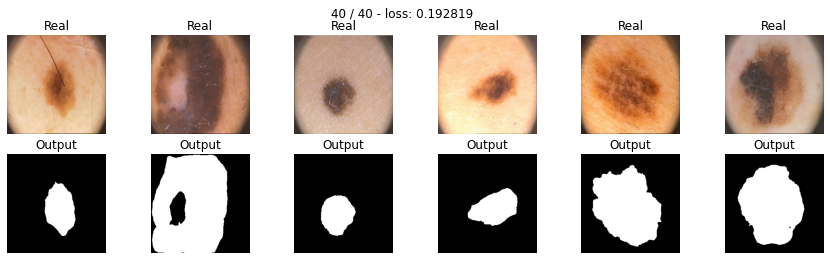

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type UNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
unet_model_bce = UNet().to(device)
path = 'unet_bce.pt'
max_epochs = 40
optimizer = torch.optim.Adam(unet_model_bce.parameters())
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
train_loss_unet_bce, val_loss_unet_bce, train_score_unet_bce, val_score_unet_bce = train(unet_model_bce, optimizer, bce_loss, max_epochs, data_tr, data_val, scheduler, path)

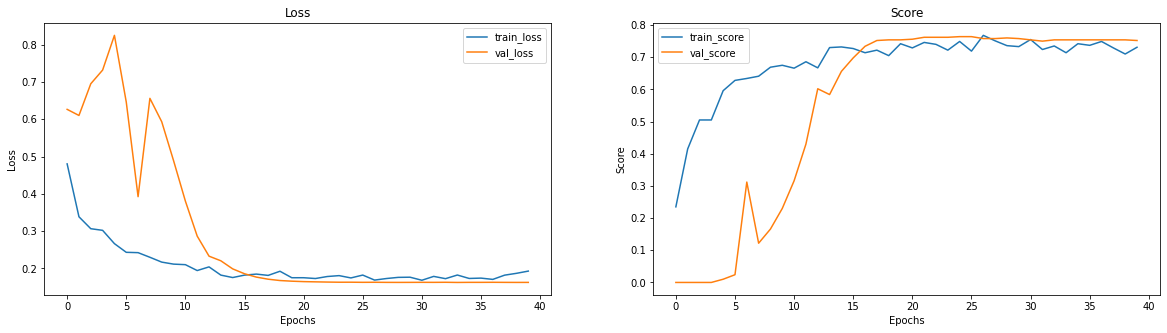

In [0]:
visualize(train_loss_unet_bce, val_loss_unet_bce, train_score_unet_bce, val_score_unet_bce)

In [0]:
path = 'unet_bce.pt'
model = torch.load(path)
print(score_model(model, iou_pytorch, data_val))
print(score_model(model, iou_pytorch, data_ts))

0.7519999742507935
0.6859999895095825


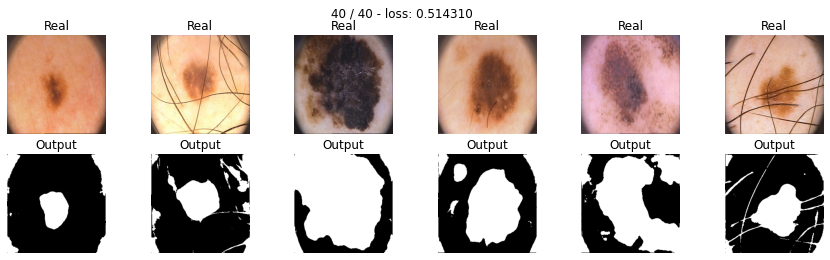

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type UNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
unet_model_dice = UNet().to(device)
path = 'unet_dice.pt'
max_epochs = 40
optimizer = torch.optim.Adam(unet_model_dice.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
train_loss_unet_dice, val_loss_unet_dice, train_score_unet_dice, val_score_unet_dice  = train(unet_model_dice, optimizer, dice_loss, max_epochs, data_tr, data_val, scheduler, path)

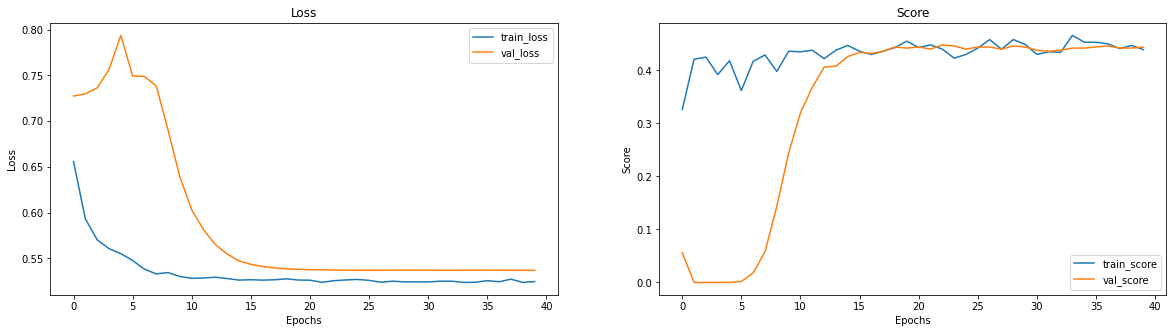

In [0]:
visualize(train_loss, val_loss, train_score, val_score)

In [0]:
path = 'unet_dice.pt'
model = torch.load(path)
print(score_model(model, iou_pytorch, data_val))
print(score_model(model, iou_pytorch, data_ts))

0.4440000057220459
0.4360000044107437


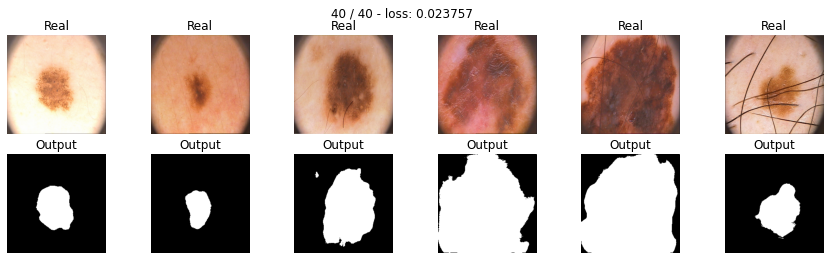

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type UNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
unet_model_focal = UNet().to(device)
path = 'unet_focal.pt'
max_epochs = 40
optimizer = torch.optim.Adam(unet_model_focal.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
train_loss_unet_focal, val_loss_unet_focal, train_score_unet_focal, val_score_unet_focal  = train(unet_model_focal, optimizer, focal_loss, max_epochs, data_tr, data_val, scheduler, path)

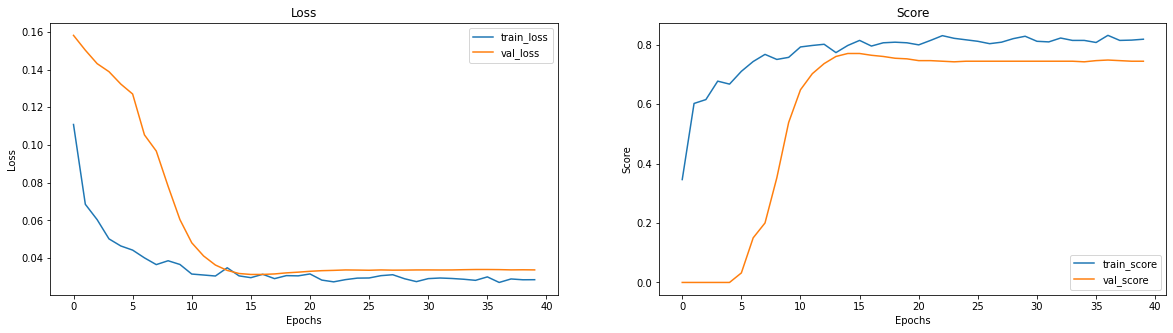

In [0]:
visualize(train_loss, val_loss, train_score, val_score)

In [0]:
model = torch.load(path)
print(score_model(model, iou_pytorch, data_val))
print(score_model(model, iou_pytorch, data_ts))

0.7440000474452972
0.7200000286102295


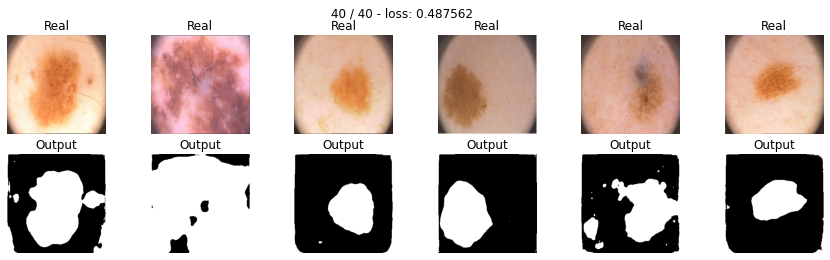

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type UNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
unet_model_tversky = UNet().to(device)
path = 'unet_tversky.pt'
max_epochs = 40
optimizer = torch.optim.Adam(unet_model_tversky.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
train_loss_unet_tversky, val_loss_unet_tversky, train_score_unet_tversky, val_score_unet_tversky  = train(unet_model_tversky, optimizer, tversky_loss, max_epochs, data_tr, data_val, scheduler, path)

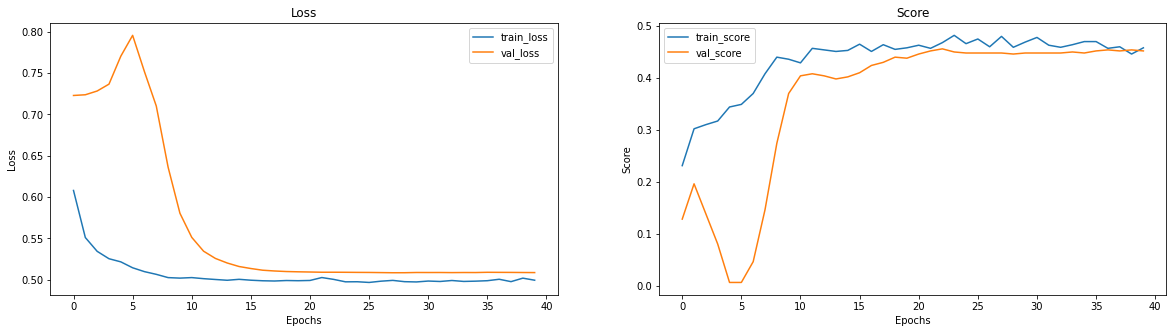

In [0]:
visualize(train_loss, val_loss, train_score, val_score)

In [0]:
path = 'unet_tversky.pt'
model = torch.load(path)
print(score_model(model, iou_pytorch, data_val))
print(score_model(model, iou_pytorch, data_ts))

0.4520000070333481
0.44199998676776886


Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [0]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(64),
            nn.ReLU(),
             nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.pool0 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))# 256 -> 128
        self.enc_conv1 =  nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.pool1 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)) # 128 -> 64
        self.enc_conv2 =  nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.pool2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))  # 64 -> 32
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.pool3 =  nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))  # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(1024),
            nn.ReLU()
        ) 

        # decoder (upsampling)
        self.upsample0 =  nn.ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)) # 16 -> 32
        self.dec_conv0 =  nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU()
        ) 
        self.upsample1 = nn.ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)) # 32 -> 64
        self.dec_conv1 =  nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256),
            nn.ReLU(),
             nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )  
        self.upsample2 = nn.ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)) # 64 -> 128
        self.dec_conv2 =  nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )   
        self.upsample3 = nn.ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)) # 128 -> 256
        self.dec_conv3 =  nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0))
        )   

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        e1 = self.enc_conv1(self.pool0(e0))
        e2 = self.enc_conv2(self.pool1(e1))
        e3 = self.enc_conv3(self.pool2(e2))

        # bottleneck
        b = self.bottleneck_conv(self.pool3(e3))

        # decoder
        # concatenate over channels dim=1
        d0 = self.dec_conv0(torch.cat([self.upsample0(b), e3], dim=1))
        d1 = self.dec_conv1(torch.cat([self.upsample1(d0), e2], dim=1))
        d2 = self.dec_conv2(torch.cat([self.upsample2(d1), e1], dim=1))
        d3 = self.dec_conv3(torch.cat([self.upsample3(d2), e0], dim=1)) # no activation
        return d3

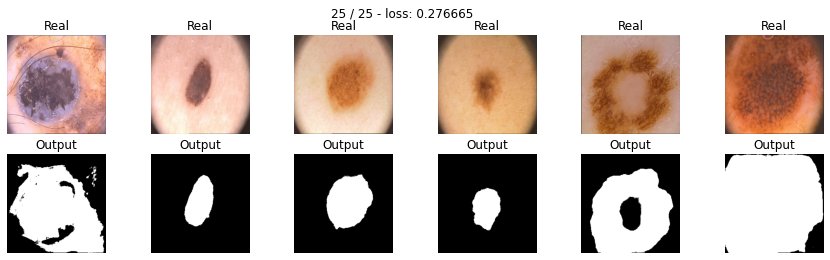

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type UNet2. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
unet2_model = UNet2().to(device)
path = 'unet2_bce.pt'
max_epochs = 25
optimizer = torch.optim.Adam(unet2_model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
train_loss_unet2_bce, val_loss_unet2_bce, train_score_unet2_bce, val_score_unet2_bce = train(unet2_model, optimizer, bce_loss, max_epochs, data_tr, data_val, scheduler, path)

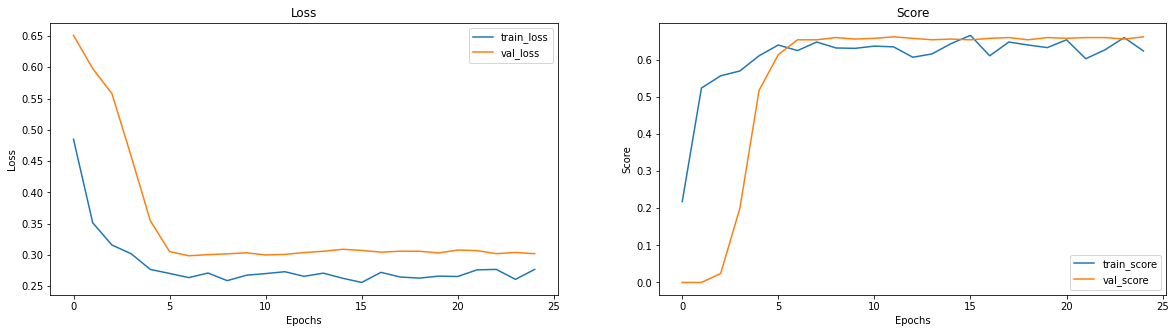

In [0]:
visualize(train_loss_unet2_bce, val_loss_unet2_bce, train_score_unet2_bce, val_score_unet2_bce)

In [0]:
model = torch.load(path)
print(score_model(model, iou_pytorch, data_val))
print(score_model(model, iou_pytorch, data_ts))

0.6620000004768372
0.684000027179718


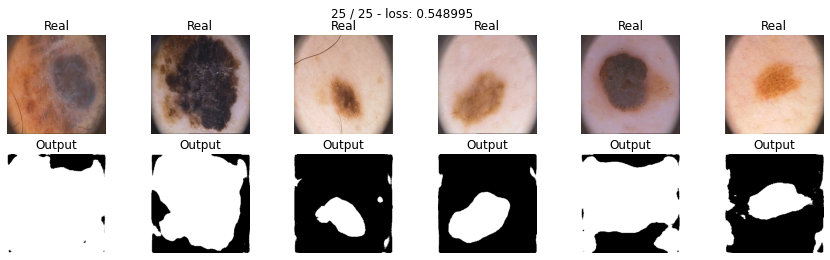

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type UNet2. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
unet2_model_dice = UNet2().to(device)
path = 'unet2_dice.pt'
max_epochs = 25
optimizer = torch.optim.Adam(unet2_model_dice.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
train_loss_unet2_dice, val_loss_unet2_dice, train_score_unet2_dice, val_score_unet2_dice = train(unet2_model_dice, optimizer, dice_loss, max_epochs, data_tr, data_val, scheduler, path)

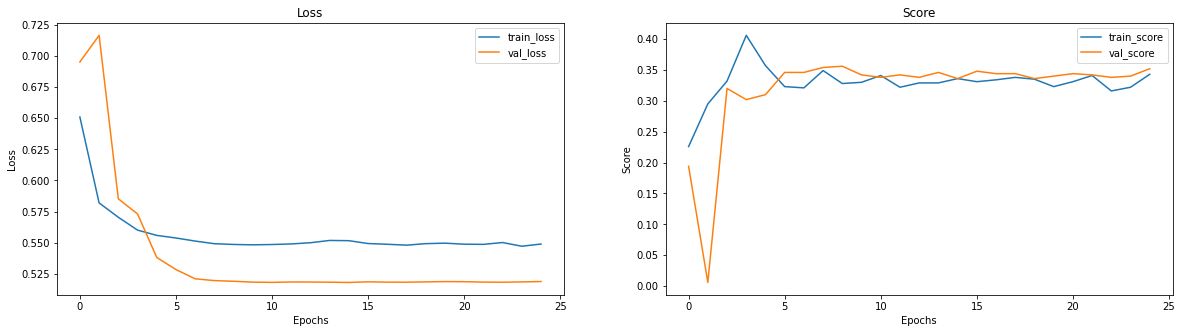

In [0]:
visualize(train_loss_unet2_dice, val_loss_unet2_dice, train_score_unet2_dice, val_score_unet2_dice)

In [0]:
model = torch.load(path)
print(score_model(model, iou_pytorch, data_val))
print(score_model(model, iou_pytorch, data_ts))

0.3520000070333481
0.32800001204013823


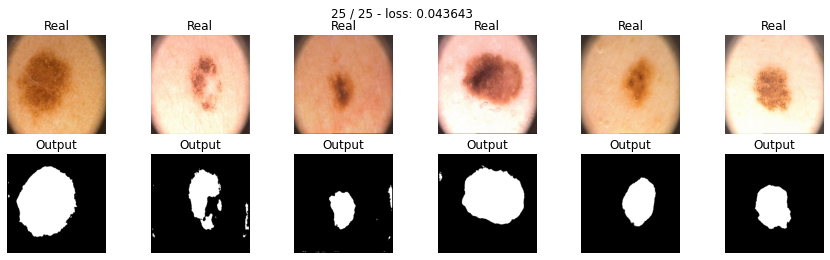

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type UNet2. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
unet2_model_focal = UNet2().to(device)
path = 'unet2_focal.pt'
max_epochs = 25
optimizer = torch.optim.Adam(unet2_model_focal.parameters())
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
train_loss_unet2_focal, val_loss_unet2_focal, train_score_unet2_focal, val_score_unet2_focal = train(unet2_model_focal, optimizer, focal_loss, max_epochs, data_tr, data_val, scheduler, path)

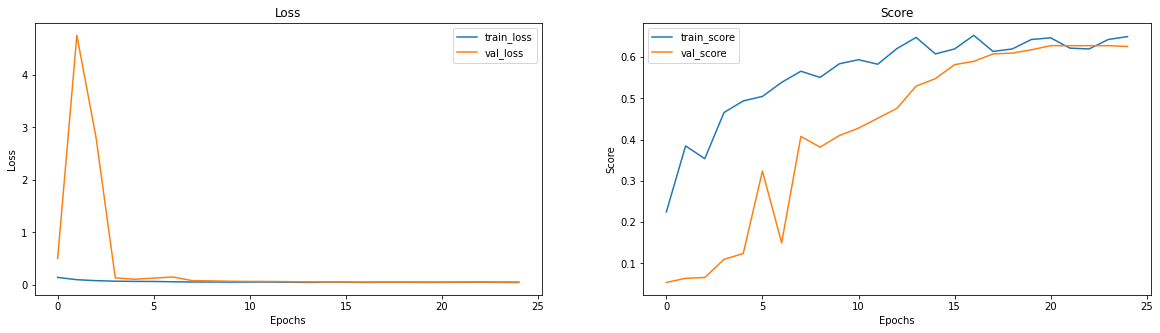

In [0]:
visualize(train_loss, val_loss, train_score, val_score)

In [0]:
model = torch.load(path)
print(score_model(model, iou_pytorch, data_val))
print(score_model(model, iou_pytorch, data_ts))

0.6259999871253967
0.593999981880188


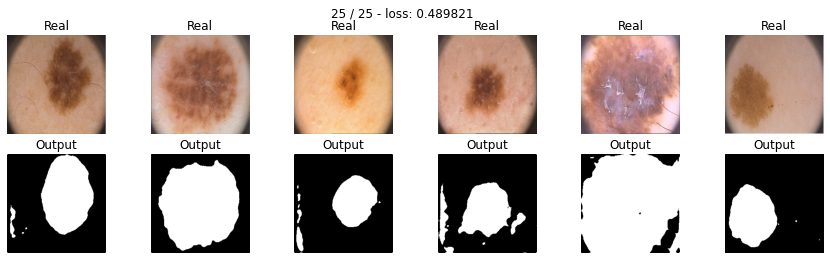

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type UNet2. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
unet2_model_tversky = UNet2().to(device)
path = 'unet2_tversky.pt'
max_epochs = 25
optimizer = torch.optim.Adam(unet2_model_tversky.parameters())
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
train_loss_unet2_tversky, val_loss_unet2_tversky, train_score_unet2_tversky, val_score_unet2_tversky = train(unet2_model_tversky, optimizer, tversky_loss, max_epochs, data_tr, data_val, scheduler, path)

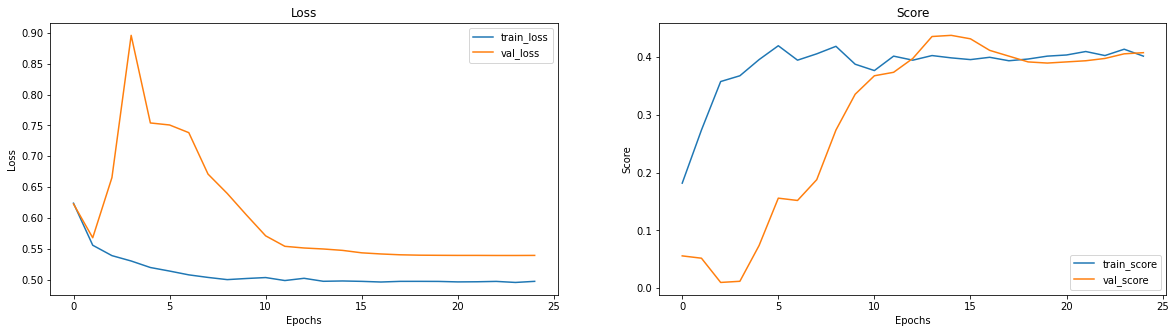

In [0]:
visualize(train_loss, val_loss, train_score, val_score)

In [0]:
model = torch.load(path)
print(score_model(model, iou_pytorch, data_val))
print(score_model(model, iou_pytorch, data_ts))

0.4079999774694443
0.43400000035762787


Сделайте вывод какая из моделей лучше

# Dilated convolutions [1 балл]



Еще один из вариантов делать upsampling и downsampling - использовать для этого *dilated convolutions*:


* Yu, Fisher, and Vladlen Koltun. "[Multi-scale context aggregation by dilated convolutions.](https://arxiv.org/pdf/1511.07122.pdf)" arXiv preprint arXiv:1511.07122 (2015).

попробуйте написать сеть DilatedUNet, которая использует в одной из предыдущих моделей dilated свертки.

In [0]:
class Dilated_UNet2(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.pool0 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2), dilation=(2, 2))# 256 -> 128
        self.enc_conv1 =  nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.pool1 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2), dilation=(2, 2)) # 128 -> 64
        self.enc_conv2 =  nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.pool2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2), dilation=(2, 2))  # 64 -> 32
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.pool3 =  nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2), dilation=(2, 2))  # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(1024),
            nn.ReLU()
        ) 

        # decoder (upsampling)
        self.upsample0 =  nn.ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(4, 4), dilation=(3, 3)) # 16 -> 32
        self.dec_conv0 =  nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU()
        ) 
        self.upsample1 = nn.ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(4, 4), dilation=(3, 3)) # 32 -> 64
        self.dec_conv1 =  nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )  
        self.upsample2 = nn.ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(4, 4), dilation=(3, 3)) # 64 -> 128
        self.dec_conv2 =  nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )   
        self.upsample3 = nn.ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(4, 4), dilation=(3, 3)) # 128 -> 256
        self.dec_conv3 =  nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0))
        )   

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        e1 = self.enc_conv1(self.pool0(e0))
        e2 = self.enc_conv2(self.pool1(e1))
        e3 = self.enc_conv3(self.pool2(e2))

        # bottleneck
        b = self.bottleneck_conv(self.pool3(e3))

        # decoder
        # concatenate over channels dim=1
        d0 = self.dec_conv0(torch.cat([self.upsample0(b), e3], dim=1))
        d1 = self.dec_conv1(torch.cat([self.upsample1(d0), e2], dim=1))
        d2 = self.dec_conv2(torch.cat([self.upsample2(d1), e1], dim=1))
        d3 = self.dec_conv3(torch.cat([self.upsample3(d2), e0], dim=1)) # no activation
        return d3


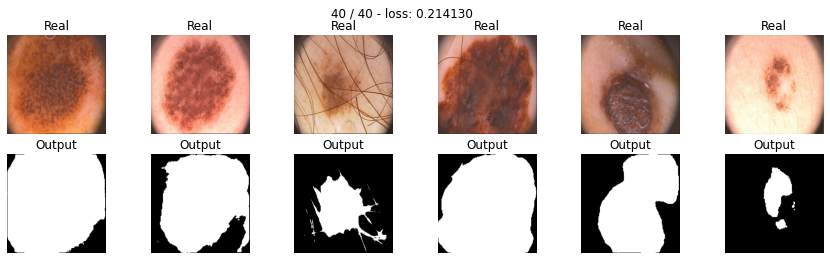

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Dilated_UNet2. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
model_dilated = Dilated_UNet2().to(device)
path = 'dilated_unet2_bce.pt'
max_epochs = 40
optimizer = torch.optim.Adam(model_dilated.parameters())
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
train_loss_dilated_unet2_bce, val_loss_dilated_unet2_bce, train_score_dilated_unet2_bce, val_score_dilated_unet2_bce = train(model_dilated, optimizer, bce_loss, max_epochs, data_tr, data_val, scheduler, path)

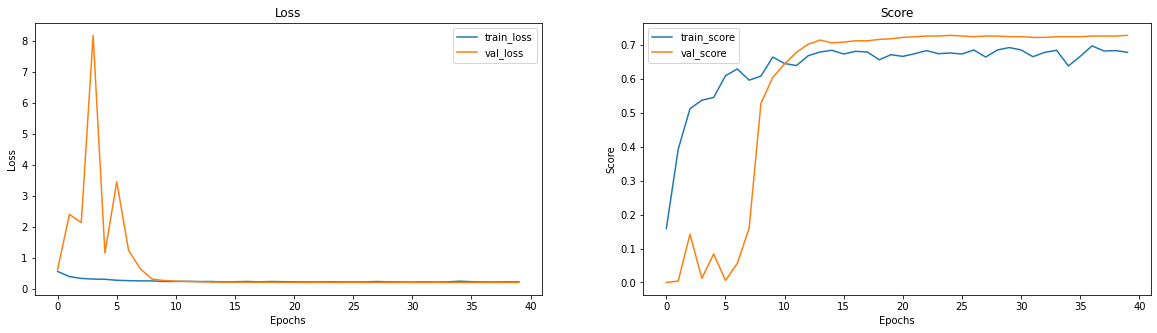

In [0]:
visualize(train_loss, val_loss, train_score, val_score)

In [0]:
path = 'dilated_unet2_bce.pt'
model = torch.load(path)
print(score_model(model, iou_pytorch, data_val))
print(score_model(model, iou_pytorch, data_ts))

0.6840000152587891
0.6879999935626984


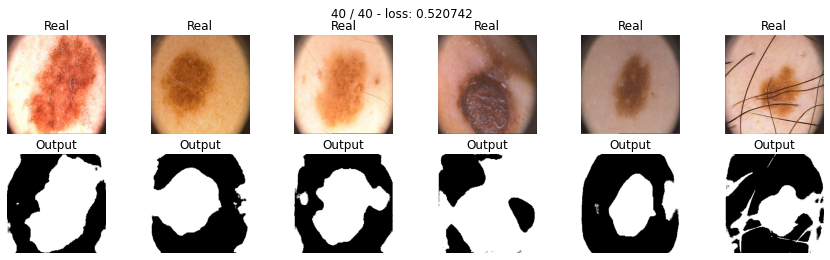

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Dilated_UNet2. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
model_dilated_dice = Dilated_UNet2().to(device)
path = 'dilated_unet2_dice.pt'
max_epochs = 40
optimizer = torch.optim.Adam(model_dilated_dice.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
train_loss_dilated_unet2_dice, val_loss_dilated_unet2_dice, train_score_dilated_unet2_dice, val_score_dilated_unet2_dice = train(model_dilated_dice, optimizer, dice_loss, max_epochs, data_tr, data_val, scheduler, path)

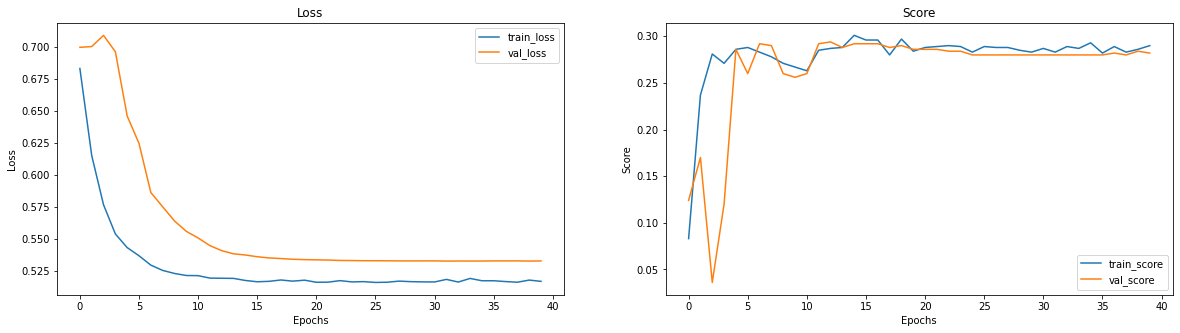

In [0]:
visualize(train_loss, val_loss, train_score, val_score)

In [0]:
path = 'dilated_unet2_dice.pt'
model = torch.load(path)
print(score_model(model, iou_pytorch, data_val))
print(score_model(model, iou_pytorch, data_ts))

0.28200000524520874
0.20400000363588333


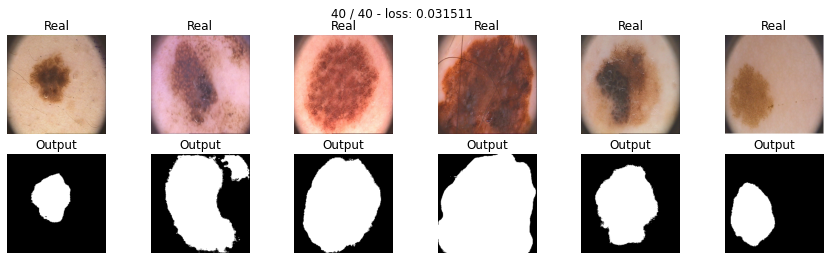

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Dilated_UNet2. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
model_dilated_focal = Dilated_UNet2().to(device)
path = 'dilated_unet2_focal.pt'
max_epochs = 40
optimizer = torch.optim.Adam(model_dilated_focal.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
train_loss_dilated_unet2_focal, val_loss_dilated_unet2_focal, train_score_dilated_unet2_focal, val_score_dilated_unet2_focal = train(model_dilated_focal, optimizer, focal_loss, max_epochs, data_tr, data_val, scheduler, path)

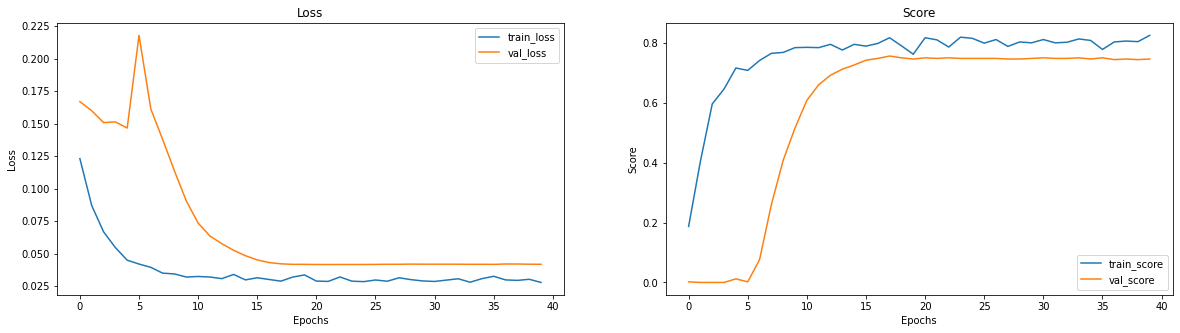

In [0]:
visualize(train_loss, val_loss, train_score, val_score)

In [0]:
path = 'dilated_unet2_focal.pt'
model = torch.load(path)
print(score_model(model, iou_pytorch, data_val))
print(score_model(model, iou_pytorch, data_ts))

0.7459999918937683
0.757999986410141


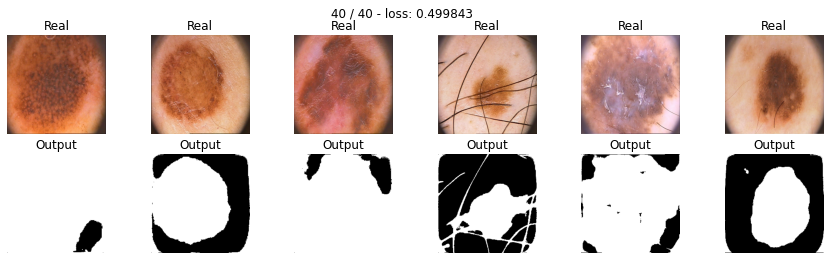

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Dilated_UNet2. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
model_dilated_tversky = Dilated_UNet2().to(device)
path = 'dilated_unet2_tversky.pt'
max_epochs = 40
optimizer = torch.optim.Adam(model_dilated_tversky.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
train_loss_dilated_unet2_tversky, val_loss_dilated_unet2_tversky, train_score_dilated_unet2_tversky, val_score_dilated_unet2_tversky = train(model_dilated_tversky, optimizer, tversky_loss, max_epochs, data_tr, data_val, scheduler, path)

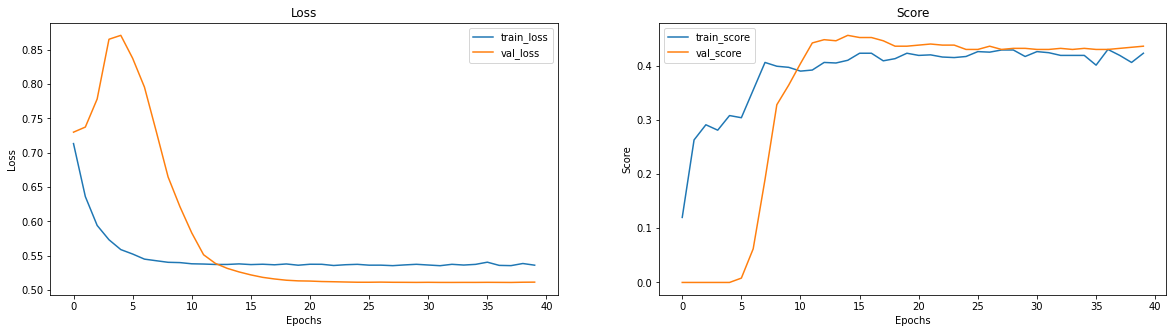

In [0]:
visualize(train_loss, val_loss, train_score, val_score)

In [0]:
path = 'dilated_unet2_tversky.pt'
model = torch.load(path)
print(score_model(model, iou_pytorch, data_val))
print(score_model(model, iou_pytorch, data_ts))

0.4359999895095825
0.4739999771118164


In [0]:
class BottleneckDilatedUNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(64),
            nn.ReLU()

        )
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)# 256 -> 128
        self.enc_conv1 =  nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0) # 128 -> 64
        self.enc_conv2 =  nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        
        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3, 3), stride=(1, 1), padding=(0, 0), dilation=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=(3, 3), stride=(1, 1), padding=(0, 0), dilation=(2, 2)),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=(3, 3), stride=(1, 1), padding=(0, 0), dilation=(4, 4)),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=(3, 3), stride=(1, 1), padding=(0, 0), dilation=(8, 8)),
            nn.BatchNorm2d(256),
            nn.ReLU()
        ) 

        # decoder (upsampling)
        self.upsample1 = nn.ConvTranspose2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(3, 3), dilation=(1, 1))  # 32 -> 64
        self.dec_conv1 =  nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )  
        self.upsample2 = nn.ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(4, 4), dilation=(3, 3))    # 64 -> 128
        self.dec_conv2 =  nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )   
        self.upsample3 = nn.ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(4, 4), dilation=(3, 3))  # 128 -> 256
        self.dec_conv3 =  nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0))
        )   

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        e1 = self.enc_conv1(self.pool0(e0))
        e2 = self.enc_conv2(self.pool1(e1))


        # bottleneck
        b = self.bottleneck_conv(e2)
        # decoder
        # concatenate over channels dim=1
        d1 = self.dec_conv1(torch.cat([self.upsample1(b), e2], dim=1))
        d2 = self.dec_conv2(torch.cat([self.upsample2(d1), e1], dim=1))
        d3 = self.dec_conv3(torch.cat([self.upsample3(d2), e0], dim=1)) # no activation
        return d3

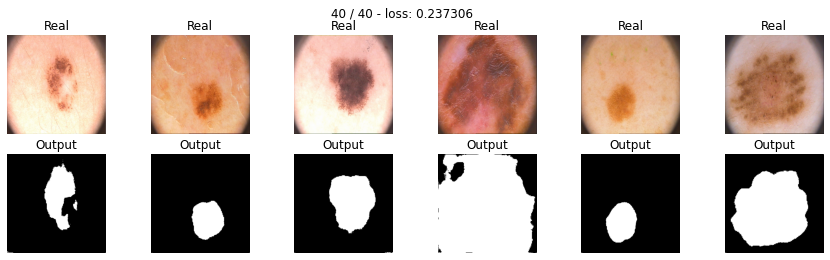

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type BottleneckDilatedUNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
# batch_size = 12 to avoid cuda out of memory
model_dilated_bottleneck_bce = BottleneckDilatedUNet().to(device)
path = 'dilated_bottleneck_bce.pt'
max_epochs = 40
optimizer = torch.optim.Adam(model_dilated_bottleneck_bce.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
train_loss_bottleneckdilatedunet_bce, val_loss_bottleneckdilatedunet_bce, train_score_bottleneckdilatedunet_bce, val_score_bottleneckdilatedunet_bce = train(model_dilated_bottleneck_bce, optimizer, bce_loss, max_epochs, data_tr, data_val, scheduler, path)

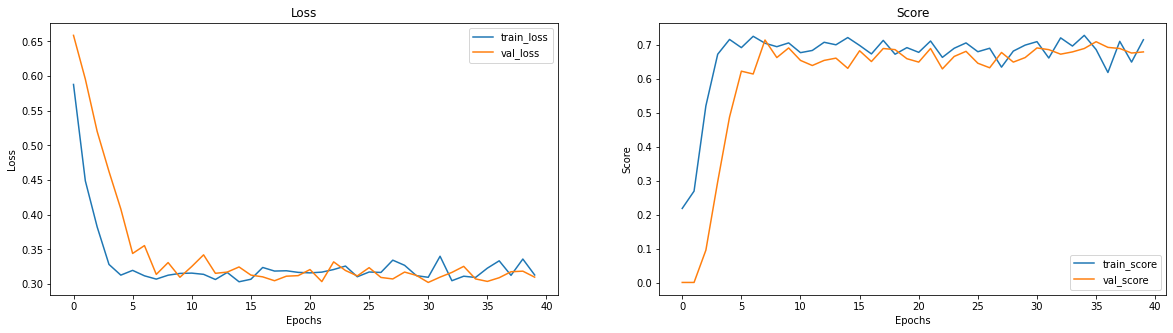

In [0]:
visualize(train_loss, val_loss, train_score, val_score)

In [0]:
path = 'dilated_bottleneck_bce.pt'
model = torch.load(path)
print(score_model(model, iou_pytorch, data_val))
print(score_model(model, iou_pytorch, data_ts))

0.5966666728258133
0.6550000190734864


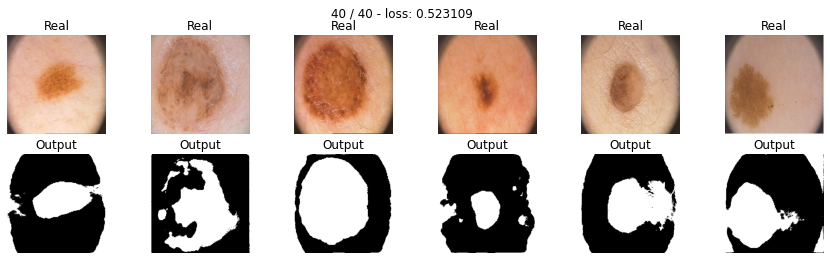

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type BottleneckDilatedUNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
# batch_size = 12
model_dilated_bottleneck_dice = BottleneckDilatedUNet().to(device)
path = 'dilated_bottleneck_dice.pt'
max_epochs = 40
optimizer = torch.optim.Adam(model_dilated_bottleneck_dice.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
train_loss_bottleneckdilatedunet_dice, val_loss_bottleneckdilatedunet_dice, train_score_bottleneckdilatedunet_dice, val_score_bottleneckdilatedunet_dice = train(model_dilated_bottleneck_dice, optimizer, dice_loss, max_epochs, data_tr, data_val, scheduler, path)

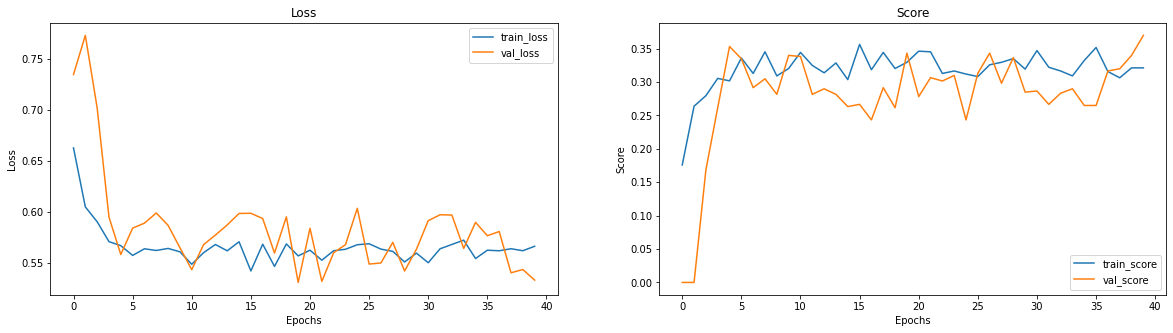

In [0]:
visualize(train_loss, val_loss, train_score, val_score)

In [0]:
path = 'dilated_bottleneck_dice.pt'
model = torch.load(path)
print(score_model(model, iou_pytorch, data_val))
print(score_model(model, iou_pytorch, data_ts))

0.32833334505558015
0.37166668176651


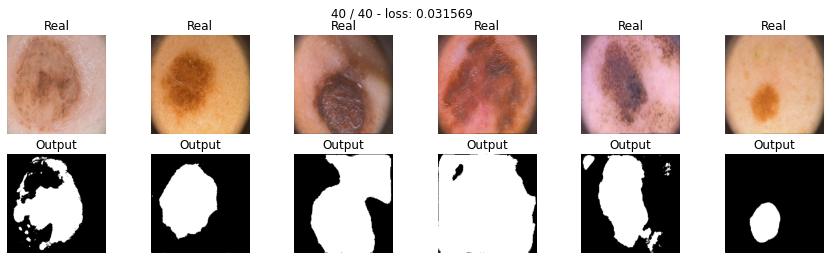

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type BottleneckDilatedUNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
# batch_size = 12
model_dilated_bottleneck_focal = BottleneckDilatedUNet().to(device)
path = 'dilated_bottleneck_focal.pt'
max_epochs = 40
optimizer = torch.optim.Adam(model_dilated_bottleneck_focal.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
train_loss_bottleneckdilatedunet_focal, val_loss_bottleneckdilatedunet_focal, train_score_bottleneckdilatedunet_focal, val_score_bottleneckdilatedunet_focal = train(model_dilated_bottleneck_focal, optimizer, focal_loss, max_epochs, data_tr, data_val, scheduler, path)

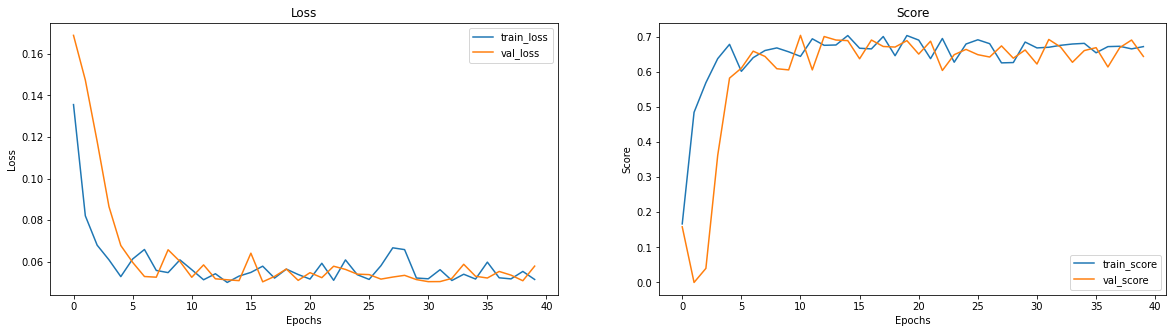

In [0]:
visualize(train_loss, val_loss, train_score, val_score)

In [0]:
path = 'dilated_bottleneck_focal.pt'
model = torch.load(path)
print(score_model(model, iou_pytorch, data_val))
print(score_model(model, iou_pytorch, data_ts))

0.6850000381469726
0.6600000262260437


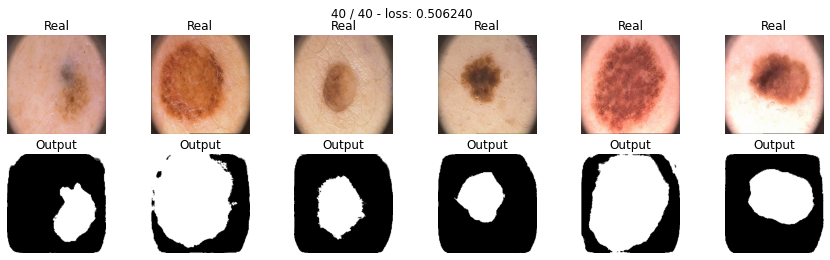

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type BottleneckDilatedUNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
# batch_size = 12
model_dilated_bottleneck_tversky = BottleneckDilatedUNet().to(device)
path = 'dilated_bottleneck_tversky.pt'
max_epochs = 40
optimizer = torch.optim.Adam(model_dilated_bottleneck_tversky.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
train_loss_bottleneckdilatedunet_tversky, val_loss_bottleneckdilatedunet_tversky, train_score_bottleneckdilatedunet_tversky, val_score_bottleneckdilatedunet_tversky = train(model_dilated_bottleneck_tversky, optimizer, tversky_loss, max_epochs, data_tr, data_val, scheduler, path)

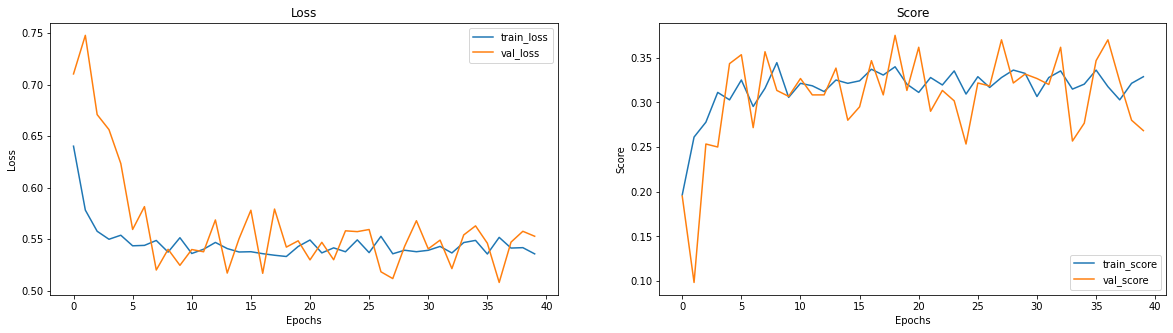

In [0]:
visualize(train_loss, val_loss, train_score, val_score)

In [0]:
path = 'dilated_bottleneck_tversky.pt'
model = torch.load(path)
print(score_model(model, iou_pytorch, data_val))
print(score_model(model, iou_pytorch, data_ts))

0.28500000536441805
0.32000001817941665




---



---



In [0]:
import pandas as pd
metric_comparison_table = pd.DataFrame({'Segnet+BCE_loss': [0.656000018119812, 0.6679999828338623],
                                        'Segnet+Focal_loss': [0.5559999644756317, 0.5760000050067902],
                                        'Segnet+Dice_loss': [0.10200000181794167, 0.11399999633431435],
                                        'Segnet+Tversky_loss': [0.5080000013113022, 0.502000018954277],
                                        'Unet+BCE_loss': [0.7019999921321869, 0.7419999837875366],
                                        'Unet+Focal_loss': [0.7440000474452972, 0.7200000286102295],
                                        'Unet+Dice_loss': [0.4440000057220459, 0.4360000044107437],
                                        'Unet+Tversky_loss': [0.4520000070333481, 0.44199998676776886],
                                        'Unet2+BCE_loss': [0.5419999957084656, 0.5360000133514404],
                                        'Unet2+Focal_loss': [0.6259999871253967, 0.593999981880188],
                                        'Unet2+Dice_loss': [0.23800000548362732, 0.3139999881386757],
                                        'Unet2+Tversky_loss': [0.4079999774694443, 0.43400000035762787],
                                        'DilatedUnet+BCE_loss': [0.6840000152587891, 0.6879999935626984],
                                        'DilatedUnet+Focal_loss': [0.7459999918937683, 0.757999986410141],
                                        'DilatedUnet+Dice_loss': [0.28200000524520874, 0.20400000363588333],
                                        'DilatedUnet+Tversky_loss': [0.4359999895095825, 0.4739999771118164],
                                        'DilatedBottleneckUnet+BCE_loss': [0.5966666728258133, 0.6550000190734864],
                                        'DilatedBottleneckUnet+Focal_loss': [0.6850000381469726, 0.6600000262260437],
                                        'DilatedBottleneckUnet+Dice_loss': [0.32833334505558015, 0.37166668176651],
                                        'DilatedBottleneckUnet+Tversky_loss': [0.28500000536441805, 0.32000001817941665]})
metric_comparison_table.index = ['train', 'val']

# Отчет (5 баллов): 
Ниже предлагается написать отчет о проделанно работе и построить графики для лоссов, метрик на валидации и тесте. 

Аккуратно сравните модели между собой и соберите наилучшую архитектуру. Проверьте каждую модель с различными лоссами. Мы не ограничиваем вас в формате отчета, но проверябщий должен отчетливо понять для чего построен каждый график, какие выводы вы из него сделали и какой общий вывод можно сделать на основании данных моделей. Если вы захотите добавить что-то еще, чтобы увеличить шансы получения максимального балла, то добавляйте отдельное сравнение.



**Сравнение IoU-метрики для моделей с различными функциями потерь**

In [0]:
metric_comparison_table

Segnet+BCE_loss  ...  DilatedBottleneckUnet+Tversky_loss
train            0.656  ...                               0.285
val              0.668  ...                               0.320

[2 rows x 20 columns]

Лучший лосс для данной задачи focal_loss, так как датасет имеет несбалансированные классы фона и пятен. Все архитектуры в связке с focal_loss показали наилучшие результаты (примерно 0.65 - 0.75).
Лучшая архитектура: DilatedUnet+Focal_loss. Худшие результаты получились в связке с dice loss и tversky loss. 

**Сравнение графиков  loss и score для каждой модели**

По всем  графикам лоссов для каждой модели (представлены ниже) можно сделать следующие выводы : \
1. Лучшие результаты для каждой модели сетей получились при использовании binary cross entropy loss и focal loss. 
2. Обучение на tversky loss и dice loss (является частным случаем tversky loss при beta=0.5) показало наихудшие результаты.  

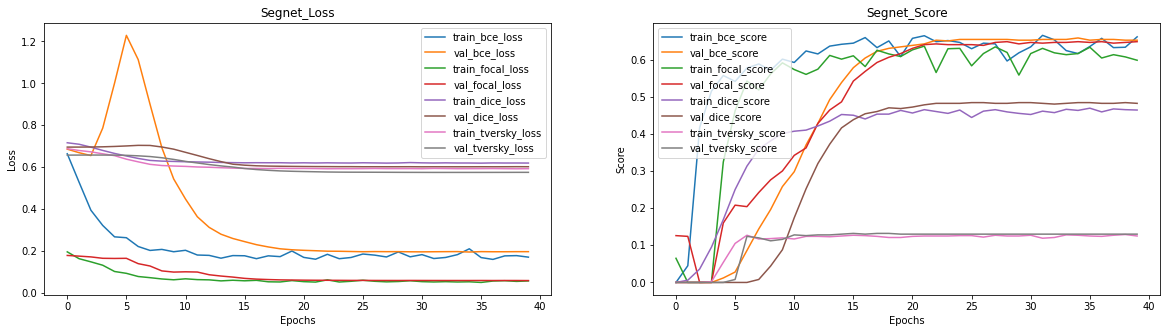

In [0]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_segnet_bce, label = 'train_bce_loss')
plt.plot(val_loss_segnet_bce, label = 'val_bce_loss')
plt.plot(train_loss_segnet_focal, label = 'train_focal_loss')
plt.plot(val_loss_segnet_focal, label = 'val_focal_loss')
plt.plot(train_loss_segnet_dice, label = 'train_dice_loss')
plt.plot(val_loss_segnet_dice, label = 'val_dice_loss')
plt.plot(train_loss_segnet_tversky, label = 'train_tversky_loss')
plt.plot(val_loss_segnet_tversky, label = 'val_tversky_loss')
plt.title('Segnet_Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_score_segnet_bce, label = 'train_bce_score')
plt.plot(val_score_segnet_bce, label = 'val_bce_score')
plt.plot(train_score_segnet_focal, label = 'train_focal_score')
plt.plot(val_score_segnet_focal, label = 'val_focal_score')
plt.plot(train_score_segnet_dice, label = 'train_dice_score')
plt.plot(val_score_segnet_dice, label = 'val_dice_score')
plt.plot(train_score_segnet_tversky, label = 'train_tversky_score')
plt.plot(val_score_segnet_tversky, label = 'val_tversky_score')
plt.title('Segnet_Score')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()
plt.show()

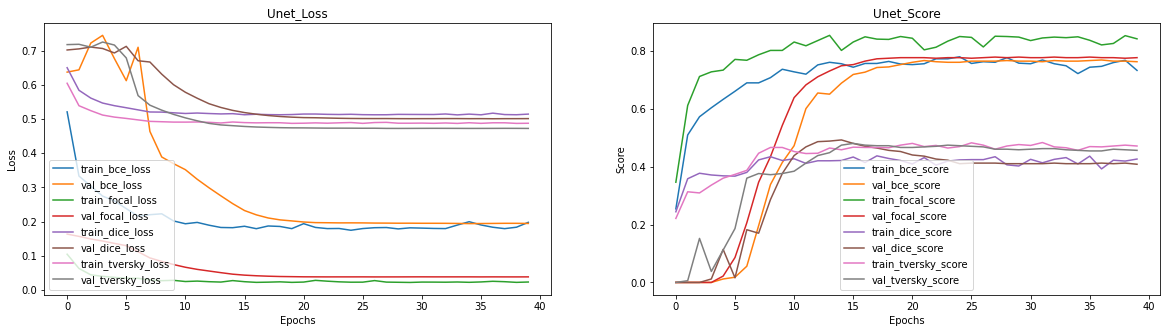

In [0]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_unet_bce, label = 'train_bce_loss')
plt.plot(val_loss_unet_bce, label = 'val_bce_loss')
plt.plot(train_loss_unet_focal, label = 'train_focal_loss')
plt.plot(val_loss_unet_focal, label = 'val_focal_loss')
plt.plot(train_loss_unet_dice, label = 'train_dice_loss')
plt.plot(val_loss_unet_dice, label = 'val_dice_loss')
plt.plot(train_loss_unet_tversky, label = 'train_tversky_loss')
plt.plot(val_loss_unet_tversky, label = 'val_tversky_loss')
plt.title('Unet_Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_score_unet_bce, label = 'train_bce_score')
plt.plot(val_score_unet_bce, label = 'val_bce_score')
plt.plot(train_score_unet_focal, label = 'train_focal_score')
plt.plot(val_score_unet_focal, label = 'val_focal_score')
plt.plot(train_score_unet_dice, label = 'train_dice_score')
plt.plot(val_score_unet_dice, label = 'val_dice_score')
plt.plot(train_score_unet_tversky, label = 'train_tversky_score')
plt.plot(val_score_unet_tversky, label = 'val_tversky_score')
plt.title('Unet_Score')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()
plt.show()

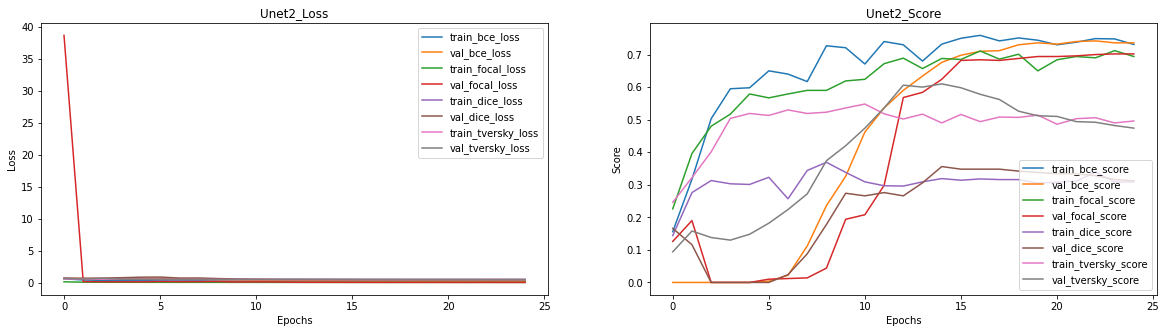

In [0]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_unet2_bce, label = 'train_bce_loss')
plt.plot(val_loss_unet2_bce, label = 'val_bce_loss')
plt.plot(train_loss_unet2_focal, label = 'train_focal_loss')
plt.plot(val_loss_unet2_focal, label = 'val_focal_loss')
plt.plot(train_loss_unet2_dice, label = 'train_dice_loss')
plt.plot(val_loss_unet2_dice, label = 'val_dice_loss')
plt.plot(train_loss_unet2_tversky, label = 'train_tversky_loss')
plt.plot(val_loss_unet2_tversky, label = 'val_tversky_loss')
plt.title('Unet2_Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_score_unet2_bce, label = 'train_bce_score')
plt.plot(val_score_unet2_bce, label = 'val_bce_score')
plt.plot(train_score_unet2_focal, label = 'train_focal_score')
plt.plot(val_score_unet2_focal, label = 'val_focal_score')
plt.plot(train_score_unet2_dice, label = 'train_dice_score')
plt.plot(val_score_unet2_dice, label = 'val_dice_score')
plt.plot(train_score_unet2_tversky, label = 'train_tversky_score')
plt.plot(val_score_unet2_tversky, label = 'val_tversky_score')
plt.title('Unet2_Score')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()
plt.show()

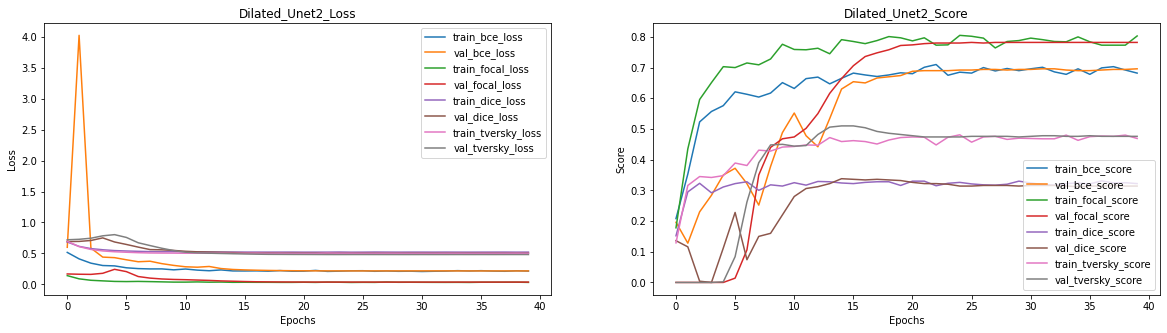

In [0]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_dilated_unet2_bce, label = 'train_bce_loss')
plt.plot(val_loss_dilated_unet2_bce, label = 'val_bce_loss')
plt.plot(train_loss_dilated_unet2_focal, label = 'train_focal_loss')
plt.plot(val_loss_dilated_unet2_focal, label = 'val_focal_loss')
plt.plot(train_loss_dilated_unet2_dice, label = 'train_dice_loss')
plt.plot(val_loss_dilated_unet2_dice, label = 'val_dice_loss')
plt.plot(train_loss_dilated_unet2_tversky, label = 'train_tversky_loss')
plt.plot(val_loss_dilated_unet2_tversky, label = 'val_tversky_loss')
plt.title('Dilated_Unet2_Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_score_dilated_unet2_bce, label = 'train_bce_score')
plt.plot(val_score_dilated_unet2_bce, label = 'val_bce_score')
plt.plot(train_score_dilated_unet2_focal, label = 'train_focal_score')
plt.plot(val_score_dilated_unet2_focal, label = 'val_focal_score')
plt.plot(train_score_dilated_unet2_dice, label = 'train_dice_score')
plt.plot(val_score_dilated_unet2_dice, label = 'val_dice_score')
plt.plot(train_score_dilated_unet2_tversky, label = 'train_tversky_score')
plt.plot(val_score_dilated_unet2_tversky, label = 'val_tversky_score')
plt.title('Dilated_Unet2_Score')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()
plt.show()

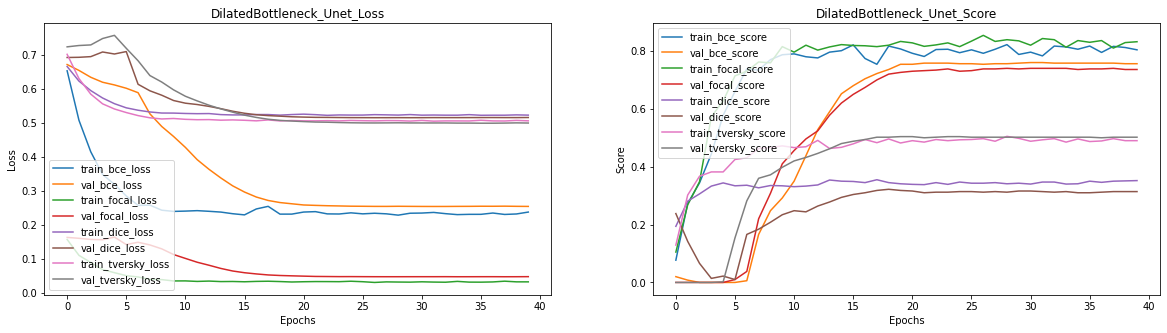

In [0]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_bottleneckdilatedunet_bce, label = 'train_bce_loss')
plt.plot(val_loss_bottleneckdilatedunet_bce, label = 'val_bce_loss')
plt.plot(train_loss_bottleneckdilatedunet_focal, label = 'train_focal_loss')
plt.plot(val_loss_bottleneckdilatedunet_focal, label = 'val_focal_loss')
plt.plot(train_loss_bottleneckdilatedunet_dice, label = 'train_dice_loss')
plt.plot(val_loss_bottleneckdilatedunet_dice, label = 'val_dice_loss')
plt.plot(train_loss_bottleneckdilatedunet_tversky, label = 'train_tversky_loss')
plt.plot(val_loss_bottleneckdilatedunet_tversky, label = 'val_tversky_loss')
plt.title('DilatedBottleneck_Unet_Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_score_bottleneckdilatedunet_bce, label = 'train_bce_score')
plt.plot(val_score_bottleneckdilatedunet_bce, label = 'val_bce_score')
plt.plot(train_score_bottleneckdilatedunet_focal, label = 'train_focal_score')
plt.plot(val_score_bottleneckdilatedunet_focal, label = 'val_focal_score')
plt.plot(train_score_bottleneckdilatedunet_dice, label = 'train_dice_score')
plt.plot(val_score_bottleneckdilatedunet_dice, label = 'val_dice_score')
plt.plot(train_score_bottleneckdilatedunet_tversky, label = 'train_tversky_score')
plt.plot(val_score_bottleneckdilatedunet_tversky, label = 'val_tversky_score')
plt.title('DilatedBottleneck_Unet_Score')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()
plt.show()